# DFINE Tutorial
## Overview

DFINE, which stands for **Dynamical Flexible Inference for Nonlinear Embeddings**, is a neural network model that is developed to enable flexible inference, whether causally, non-causally, or even in the presence of missing neural observations. To enable flexible inference, a model must achieve all the following operations simultaneously, without the need to retrain a new model or change the inference structure:

1\) Causal inference (filtering) <br>
2\) Non-causal inference (smoothing) <br>
3\) Account for missing observations, which can occur in wireless neural interfaces

DFINE achieves flexible inference. Also, DFINE’s inference is recursive and thus computationally efficient. Flexible inference is essential for developing neurotechnology, such as brain-machine interfaces (BMIs).

### Model Architecture
To achieve flexible inference, DFINE separates the model into jointly trained manifold and dynamic latent factors such that nonlinearity is captured through the manifold factors and the dynamics can be modeled in tractable linear form on this nonlinear manifold. Also, as its training loss, DFINE can use the future-step-ahead neural prediction error because of its flexible inference capability that allows it to efficiently and recursively compute this loss during training. 

Specifically, we define the two sets of latent factors as follows: 1) Manifold latent factors ${a}_t \in \mathbb{R}^{n_a \times 1}$ and 2) Dynamic latent factors ${x}_t \in \mathbb{R}^{n_x \times 1}$. 

First, the dynamic latent factors evolve in time with a linear Gaussian model: $\begin{equation}{x}_{t+1} = A{x}_t + {w}_t\tag{1}\end{equation}$ where $A \in \mathbb{R}^{n_x \times n_x}$ is the state transition matrix and ${w}_t \in \mathbb{R}^{n_x \times 1}$ is zero-mean Gaussian noise with covariance matrix $W \in \mathbb{R}^{n_x \times n_x}$. The manifold latent factors ${a}_t$ are related to the dynamic latent factors ${x}_t$ as: $\begin{equation}{a}_t = C{x}_t + {r}_t\tag{2}\end{equation}$ where $C \in \mathbb{R}^{n_a \times n_x}$ is the emission matrix and ${r}_t \times \mathbb{R}^{n_a \times 1}$ is white Gaussian noise with covariance matrix $R \in \mathbb{R}^{n_a \times n_a}$. Equations (1) and (2) form an LDM with learnable parameters $\psi = \{ A, C, W, R, {\mu}_0, \Lambda_0 \}$ where ${\mu}_0$ and $\Lambda_0$ are the initial estimate and covariance of dynamic latent factors, respectively. 

Second, to model nonlinear mappings, we used MLP autoencoders to learn the mapping between neural observations ${y}_t$ and manifold latent factors ${a}_t$. We model the decoder part as a nonlinear mapping $f_\theta(\cdot)$ from manifold latent factors to neural observations: $\begin{equation}{y}_t = f_\theta({a}_t) + {v}_t\tag{3}\end{equation}$ where $\theta$ are parameters and ${v}_t \in \mathbb{R}^{n_y \times 1}$ is a white Gaussian noise with covariance $V \in \mathbb{R}^{n_y \times n_y}$. Equations (1)-(3) together form the generative model. 

For inference, we also need the mapping from ${y}_t$ to ${a}_t$, which we characterize as: $\begin{equation}{a}_t = f_\phi ({y}_t)\tag{4}\end{equation}$ where $f_\phi(\cdot)$ represents the encoder in the autoencoder structure and is parameterized by another MLP. All equations above are trained together end-to-end, rather than separately. Further, the middle manifold layer in equation (2) explicitly incorporates a
stochastic noise variable $r_t$, whose covariance is learned during training, allowing the nonlinearity with respect to the dynamic latent factors to be stochastic in DFINE. To help with robustness to noise and stochasticity during inference, DFINE learns all the stochastic noise distribution parameters during training, which are then explicitly accounted for at inference.


### The Inference Problem
Using the equations above, we can infer both the manifold and dynamic latent factors from neural observations ${y}_{1:T}$, where $T$ is the total number of time steps for the observations. We use subscript $t|k$ to denote the inferred latent factors at time $t$ given observations up to time $k$, ${y}_{1:k}$. Thus, $t|t$ denotes filtering (causal) inference given ${y}_{1:t}$, $t+k|t$ denotes the $k$-step-ahead prediction given $y_{1:t}$, and $t|T$ denotes smoothing (non-causal) inference given ${y}_{1:T}$.

The inference method is shown in Figure 1b in the paper and is as follows. We first directly but statically obtain an initial estimate of ${a}_t$ based on ${y}_t$ with ${\hat{a}}_t = f_\phi({y}_t)$ in equation (4), to provide the noisy observations of the dynamical model, that is, ${\hat{a}}_t$. Having obtained ${\hat{a}}_t$, we can now use the dynamical part of the model in equations (1) and (2) to infer ${x}_{t|t}$ with Kalman filtering from ${\hat{a}}_{1:t}$, and infer ${x}_{t|T}$ with Kalman smoothing from ${\hat{a}}_{1∶T}$. We can then infer the manifold latent factor as ${a}_{t|t} = C{x}_{t|t}$ and ${a}_{t|T} = C{x}_{t|T}$ on the basis of equation (2). Similarly, we can obtain the filtered neural activity ${y}_{t|t}$ and smoothed neural activity ${y}_{t|T}$ using equation (3) as ${y}_{t|t} = f_{\theta}({a}_{t|t})$ and ${y}_{t|T} = f_{\theta}({a}_{t|T})$, respectively.

To obtain the $k$-step-ahead predicted neural activity ${y}_{t+k|t}$, we first recursively forward predict the dynamic latent factors $k$ time-steps with the Kalman predictor, and obtain ${x}_{t+k|t}$. Then, we can compute the $k$-step-ahead predictions of manifold latent factors and neural observations with ${a}_{t+k|t} = C{x}_{t+k|t}$ and ${y}_{t+k|t} = f_{\theta}({a}_{t+k|t})$, respectively.
 
### Training Loss Function
Having established the DFINE model and its inference, we can learn the model parameters $\psi, \theta, \phi$ by minimizing:  $\begin{equation}L(\psi, \theta, \phi) = \sum_{k=1}^K \sum_{t=1}^{T-k} e({y}_{t+k|t}, {y}_{t+k}) + \lambda_{reg} L_2 (\theta, \phi)\tag{5}\end{equation}$ where $K$ denotes the maximum horizon for future-step-ahead prediction, $e(\cdot, \cdot)$ denotes the error measure which is taken as mean-squared error (MSE) loss, $L_2(\cdot)$ is L2 regularization for the autoencoder parameters $\{\theta, \phi\}$ to prevent overfitting, and $\lambda_{reg}$ is the L2 regularization loss scale (see config_dfine.py). 
 
### Training tips and hyperparameters
DFINE does not have many hyperparameters to tune. Yet **it may be necessary to search over a grid of the following hyperparameters to find the best performing ones for a given dataset (especially for L2 regularization loss scale)**:
- L2 regularization loss scale, config.loss.scale_l2. For hyperparameter search, you can use a small grid such as [1e-4, 5e-4, 1e-3, 2e-3] after z-scoring the signals (see below).
- $K$, future-step-ahead prediction horizon provided as a list, config.loss.steps_ahead
- Encoder/decoder architecture, i.e., number of hidden layers and units in each layer, config.model.hidden_layer_list
- Setting $n_a$ higher than $n_y$ may lead to overfitting, it's recommended that $n_a \leq n_y$
- As we show in Extended Data Fig. 8, it's recommended to set $n_a = n_x$ to reduce the hyperparameter search complexity

For default values of all hyperparameters, please see config_dfine.py. For the future-step-ahead prediction horizon, we used $K=4$, or config.loss.steps_ahead = [1,2,3,4] for DFINE. 

It is important to note that for neural signals, we performed **z-scoring** which is highly recommended, please see below and time_series_utils.z_score_tensor. Recommendations above for L2 regularization scale are with z-scoring, which can affect the choice of L2 regularization scale.


**DFINE is currently implemented for continuous-valued signals**.

## Setting up the Virtual Environment

First, let's make sure the virtual environment requirements are satisfied.

In [ ]:
!pip install --upgrade pip
!pip install -r requirements.txt 

We installed/checked all required packages to run DFINE training, let's start with importing the following libraries.

In [2]:
%matplotlib inline

import random 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

from config_dfine import get_default_config
from trainers.TrainerDFINE import TrainerDFINE
from datasets import DFINEDataset
from time_series_utils import z_score_tensor, get_nrmse_error

# Sets the seed
seed = 0
def set_seed(seed=0):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

# Plotting helper functions
def set_matplotlib_starter_nature():   
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 15}
    matplotlib.rc('font', **font)  
    
def set_plot_settings_nature(fig,ax_list):
    for ax in ax_list:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_color('black')
        ax.spines["left"].set_color('black')
        ax.tick_params('both', length=8, width=1, which='major', color='black')
        ax.tick_params('both', length=4, width=0.5, which='minor', color='black')

## Simulating a nonlinear manifold
Next, we load the data for the nonlinear Swiss-roll manifold similar to Figure 3 in the paper. The nonlinear equations to generate the Swiss-roll manifold are (see Supplementary Note 1): $\begin{equation}e_1 = 0.5 d_r \cos(d_r)\tag{1}\end{equation}$ $\begin{equation} e_2 = 0.5 d_h\tag{2}\end{equation}$ $\begin{equation} e_3 = 0.5 d_r \sin(d_r)\tag{3}\end{equation}$ where $e_1$, $e_2$ and $e_3$ are 3D manifold embeddings, and $d_r$ and $d_h$ are 2D Swiss-roll coordinates. 

We generate trajectories over the manifold by first generating a walk on the Swiss-roll manifold's local coordinate space with the following equation (after normalizing $d_t$): $\begin{equation}{d}_{t+1} = A{d}_t + {b} + {q}_t\tag{4}\end{equation}$ where ${d}_t = \begin{bmatrix} d_{r_t} \\ d_{h_t} \end{bmatrix}$, $A$ is the state transition matrix, ${b}$ is the input term and ${q}_t$ is zero-mean Gaussian noise with diagonal covariance matrix $Q$.

We then generate the high-dimensional neural observations ${y}_t$ from the generated trajectories on the Swiss-roll manifold as: $\begin{equation}{y}_t = T{e}_t + {o}_t \tag{5}\end{equation}$ where ${e}_t = \begin{bmatrix} e_{1_t} \\ e_{2_t} \\ e_{3_t} \end{bmatrix}$, ${o}_t$ is zero-mean Gaussian noise with diagonal covariance matrix $O$, $T$ is the emission matrix whose upper left 3x3 block is identity for visualization purposes and the rest of the elements are drawn randomly. Please see Supplementary Note 1 for details.

Now, let's load the Swiss-roll dataset.

In [3]:
# Load the Swiss-roll data and true UKF predictions
swiss_roll = torch.load('./data/swiss_roll.pt')

y = swiss_roll['y'] # High-dim noisy observations
y_no_noise = swiss_roll['y_no_noise'] # High-dim noise free observations
true_y_pred = swiss_roll['true_y_pred'] # UKF predictions with true system
e = swiss_roll['e'] # Swiss-roll manifold datapoints where dh and dr and randomly sampled, for visualization purposes only

num_trials, num_steps, dim_y = y.shape

Next, let's visualize a latent trajectory on the Swiss-roll manifold in one trial, as well as the first 3 dimensions of the associated noisy neural observations. We also show the nonlinear Swiss-roll manifold over which the trajectory evolves in grey (grey points are samples from the manifold).

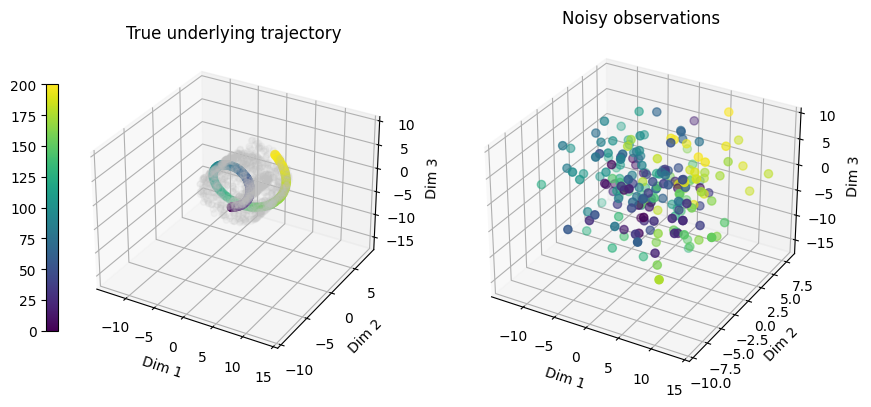

In [4]:
# Visualize a Swiss-roll trajectory
trial_plot = 0

# Plots the generated Swiss-roll manifold, the trajectory on it, and the first 3 dimensions of the noisy observations
# Note since the emission matrix's upper left 3x3 block is taken as identity for visualization, 
# the trajectory is the first 3 dimensions of y_no_noise, i.e., y before noise is added.
def plot_traj_3D(y, y_no_noise, e, trial):
    num_samples = y.shape[1]
    color_index = range(num_samples)
    color_map = plt.cm.get_cmap('viridis')
    
    xlim = [y[trial, :, 0].min(), y[trial, :, 0].max()]
    ylim = [y[trial, :, 1].min(), y[trial, :, 1].max()]
    zlim = [y[trial, :, 2].min(), y[trial, :, 2].max()]
    
    f = plt.figure(figsize=(10,8))
    ax = f.add_subplot(121, projection='3d')
    ax_m = ax.scatter(y_no_noise[trial, :, 0].numpy(), y_no_noise[trial, :, 1].numpy(), y_no_noise[trial, :, 2].numpy(), c=color_index, vmin=0, vmax=num_samples, s=35, cmap=color_map)
    ax.scatter(e[:, 0].numpy(), e[:, 1].numpy(), e[:, 2].numpy(), color='#C0C0C0', alpha=0.1)
    f.colorbar(ax_m, fraction=0.046, pad=0.04, shrink=0.4, location='left')
    ax.set_xlabel('Dim 1')
    ax.set_ylabel('Dim 2')
    ax.set_zlabel('Dim 3')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(zlim)
    ax.set_title(f'True underlying trajectory')

    ax = f.add_subplot(122, projection='3d')
    ax.scatter(y[trial, :, 0].numpy(), y[trial, :, 1].numpy(), y[trial, :, 2].numpy(), c=color_index, vmin=0, vmax=num_samples, s=35, cmap=color_map)
    ax.set_xlabel('Dim 1')
    ax.set_ylabel('Dim 2')
    ax.set_zlabel('Dim 3')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(zlim)
    ax.set_title(f'Noisy observations')
    plt.show()

plot_traj_3D(y, y_no_noise, e, trial_plot)

## DFINE Training

At this point, the data is loaded. Now, let's get the default DFINE config, and change the dimensionality related hyperparameters, result saving directory and other parameters if desired (see config_dfine.py for explanations and default values). As shown in the paper, Extended Data Fig. 8, $n_a = n_x$ is a reasonable choice and reduces the computational complexity for dimension search (config.model.dim_x and config.model.dim_a) and for the Swiss-roll simulation we set them to dimensionality of $d_t$, which is 2. Please also see other "Training tips and hyperparameters" mentioned at the beginning of the tutorial.

**L2 regularization loss scale is dependent on the observation data scale, and steps_ahead as they affect the model loss significantly. Therefore, we highly recommend a small grid search for these hyperparameters.**

**For the nonlinear manifold simulations, 4 layers of 20 units was used. However, for the Lorenz simulations and data analyses in the paper, we used 3 layers of 32 units.**

With the generated config, we initialize the TrainerDFINE object, which takes care of model training and inference.

In [5]:
# Set the seed for reproducibility
set_seed(seed)

# Get default DFINE config 
config = get_default_config()

# Change desired hyperparameters (for nonlinear manifold simulations)
config.seed = seed
config.model.dim_y = dim_y
config.model.dim_a = 2
config.model.dim_x = 2
config.model.hidden_layer_list = [20,20,20,20] 
config.loss.scale_l2 = 0
config.model.save_dir = f'./results/swiss_roll/'

# Initialize DFINE Trainer
trainer = TrainerDFINE(config=config)

The last step before model training is training and test dataset/dataloader generation. We use 80% of the trials for training, and the remaining 20% for test. If someone desires a hyperparameter search, an inner cross-validation can be performed by splitting the training dataset into training and validation datasets, where hyperparameters are tuned based on performance on the validation dataset (such as one-step-ahead prediction MSE, correlation coefficient, etc.).

DFINE can also be trained and do inference on a continuous stream of data. If desired, the generated trials can be concatenated to form a single, long continuous data stream and DFINE can be trained on that and inference can be performed on that as well.

As noted above, for all analyses in the paper, we performed **z-scoring** across time on neural signals whose statistics are obtained on the training set. We follow the same structure here.

In [6]:
# Split data into training and test datasets
train_ratio = 0.8
num_train_trials = int(train_ratio * num_trials)
num_test_trials = num_trials - num_train_trials

train_y = y[:num_train_trials, ...]
train_true_y_pred = true_y_pred[:num_train_trials, ...]
train_y_no_noise = y_no_noise[:num_train_trials, ...]

test_y = y[num_train_trials:, ...]
test_true_y_pred = true_y_pred[num_train_trials:, ...]
test_y_no_noise = y_no_noise[num_train_trials:, ...]

# Z-score the observation tensors
train_y_zsc, mean_y, std_y = z_score_tensor(train_y, fit=True)
train_y_no_noise_zsc, _, _ = z_score_tensor(train_y_no_noise, mean=mean_y, std=std_y, fit=False)
test_y_zsc, _, _ = z_score_tensor(test_y, mean=mean_y, std=std_y, fit=False)
test_y_no_noise_zsc, _, _ = z_score_tensor(test_y_no_noise, mean=mean_y, std=std_y, fit=False)

# Create DFINE dataset objects and torch dataloaders
train_dataset = DFINEDataset(y=train_y_zsc)
test_dataset = DFINEDataset(y=test_y_zsc)

train_loader = DataLoader(train_dataset, batch_size=config.train.batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config.train.batch_size, shuffle=False)

Now, it's time for training. Running 'trainer.train' starts training and after training is complete, we call 'trainer.save_encoding_results' to perform inference on training and test datasets. If you want to save the inference results in a file named 'encoding_results.pt' under config.model.save_dir, please make save_results True.

In [7]:
# Start training
trainer.train(train_loader=train_loader,
             valid_loader=test_loader) 

# After training is completed, save inference results 
train_loader = DataLoader(train_dataset, batch_size=config.train.batch_size, shuffle=False) # make shuffle False to keep track of segment ids
encoding_results = trainer.save_encoding_results(train_loader=train_loader,
                                                valid_loader=test_loader, 
                                                save_results=False)

Epoch 1, TRAIN: 100%|██████████| 7/7 [00:02<00:00,  2.44batch/s]
12/10/2023 02:32:58 PM - DFINE Logger - INFO - Epoch 1, TRAIN
1_step_mse: 0.85620
2_steps_mse: 0.85997
3_steps_mse: 0.86429
4_steps_mse: 0.86877
reg_loss: 0.00000, scale_l2: 0.00000
model_loss: 3.44923, total_loss: 3.44923

Epoch 1, VALID: 100%|██████████| 2/2 [00:00<00:00,  6.79batch/s]
12/10/2023 02:33:02 PM - DFINE Logger - INFO - Epoch 1, VALID
1_step_mse: 0.60162
2_steps_mse: 0.60788
3_steps_mse: 0.61553
4_steps_mse: 0.62450
reg_loss: 0.00000, scale_l2: 0.00000
model_loss: 2.44953, total_loss: 2.44953

Epoch 10, TRAIN: 100%|██████████| 7/7 [00:03<00:00,  2.31batch/s]
12/10/2023 02:33:34 PM - DFINE Logger - INFO - Epoch 10, TRAIN
1_step_mse: 0.18559
2_steps_mse: 0.18486
3_steps_mse: 0.18543
4_steps_mse: 0.18727
reg_loss: 0.00000, scale_l2: 0.00000
model_loss: 0.74314, total_loss: 0.74314

Epoch 10, VALID: 100%|██████████| 2/2 [00:00<00:00,  6.89batch/s]
12/10/2023 02:33:34 PM - DFINE Logger - INFO - Epoch 10, VALID
1_

## DFINE can learn the dynamics.

Next, we plot the one-step ahead normalized root MSE (NRMSE) values of DFINE on the test data throughout the training vs. number of epochs, as well as that of the true system. The true system NRMSE is obtained using a UKF that uses the true system parameters (predictions are provided in the swiss_roll.pt datafile). 

Note that DFINE NRMSEs for the test (or validation) dataset are computed by valid_epoch function after every epoch while evaluating the model, and these values are bookkept under the trainer object. Please see TrainerDFINE.py.

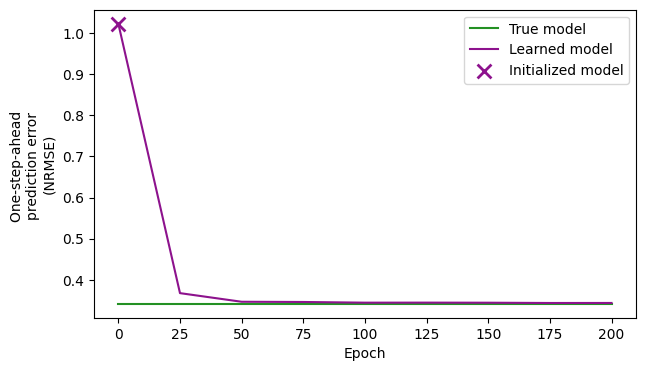

In [8]:
def plot_nrmse_convergence(true_one_step_nrmse, dfine_one_step_nrmse_list, resolution=1):
    # Downsample with desired resolution
    num_epochs = len(dfine_one_step_nrmse_list) - 1
    dfine_one_step_nrmse_list = dfine_one_step_nrmse_list[::resolution]
    x = np.arange(0, len(dfine_one_step_nrmse_list))

    # Plot the one-step-ahead prediction NRMSE of DFINE over the course of training, computed by valid_epoch function during model evaluation
    f = plt.figure(figsize=(7,4))
    ax = f.add_subplot(111)
    plt.plot(x, torch.ones(len(dfine_one_step_nrmse_list))*true_one_step_nrmse, color='#239023', label='True model')
    plt.plot(x, dfine_one_step_nrmse_list, color='#8D128D', label='Learned model')
    plt.scatter(0, dfine_one_step_nrmse_list[0], s=100, color='#8D128D', marker='x', linewidth=2, label='Initialized model')

    # Set the ticks
    xticks = np.arange(0, num_epochs+1, resolution)
    ax.set_xticks(x)
    ax.set_xticklabels(xticks)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('One-step-ahead \nprediction error \n(NRMSE)')
    plt.legend()

# One-step-ahead prediction with UKF by using the TRUE system
_, true_test_one_step_nrmse = get_nrmse_error(test_y[:, 1:, :], test_true_y_pred)
# DFINE NRMSEs on the test (or validation) dataset are computed throughout the training
# during model evaluation and bookkept under the trainer object
dfine_test_one_step_nrmse_list = trainer.training_valid_one_step_nrmses 

# Plot the NRMSE convergence over the course of training
plot_nrmse_convergence(true_test_one_step_nrmse, dfine_test_one_step_nrmse_list, resolution=25)

We see that DFINE’s one-step ahead NRMSE converges to that of the true model. Now, let's plot a trial of filtered trajectory inferred by DFINE in the test dataset.

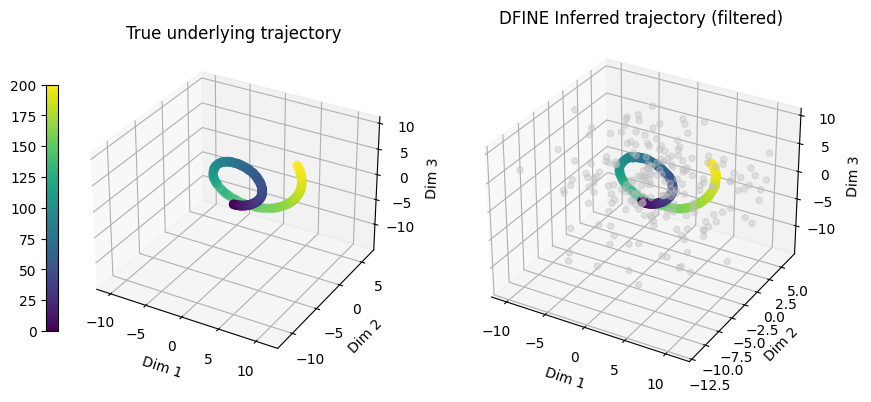

In [9]:
# Filtering with DFINE
dfine_test_y_filter_zsc = encoding_results['batch_inference']['y_filter']['valid']
dfine_test_y_filter = dfine_test_y_filter_zsc * std_y + mean_y # reverting z-scoring

# Plots the true and reconstructed trajectory on the Swiss-roll manifold
def plot_reconst_traj_3D(y, y_hat, y_no_noise, trial):
    num_samples = y.shape[1]
    color_index = range(num_samples)
    color_map = plt.cm.get_cmap('viridis')
    
    xlim = [y[trial, :, 0].min(), y[trial, :, 0].max()]
    ylim = [y[trial, :, 1].min(), y[trial, :, 1].max()]
    zlim = [y[trial, :, 2].min(), y[trial, :, 2].max()]

    f = plt.figure(figsize=(10,8))
    ax = f.add_subplot(121, projection='3d')
    ax_m = ax.scatter(y_no_noise[trial, :, 0].numpy(), y_no_noise[trial, :, 1].numpy(), y_no_noise[trial, :, 2].numpy(), c=color_index, vmin=0, vmax=num_samples, s=35, cmap=color_map)
    f.colorbar(ax_m, fraction=0.046, pad=0.04, shrink=0.4, location='left')
    ax.set_xlabel('Dim 1')
    ax.set_ylabel('Dim 2')
    ax.set_zlabel('Dim 3')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(zlim)
    ax.set_title('True underlying trajectory')

    ax = f.add_subplot(122, projection='3d')
    ax_m = ax.scatter(y_hat[trial, :, 0].numpy(), y_hat[trial, :, 1].numpy(), y_hat[trial, :, 2].numpy(), c=color_index, vmin=0, vmax=num_samples, s=35, cmap=color_map)
    ax.scatter(y[trial, :, 0].numpy(), y[trial, :, 1].numpy(), y[trial, :, 2].numpy(), color='#C0C0C0', alpha=0.4) # noisy observations
    ax.set_xlabel('Dim 1')
    ax.set_ylabel('Dim 2')
    ax.set_zlabel('Dim 3')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(zlim)
    title = 'DFINE Inferred trajectory (filtered)'
    ax.set_title(title)
    plt.show()

# Plot DFINE inferred filtered observations
plot_reconst_traj_3D(test_y, dfine_test_y_filter, test_y_no_noise, trial_plot)

We see that DFINE’s inferred trajectory using causal filtering is nearly identical to the true trajectory. Note that the grey dots on the right are the noisy observations from which DFINE infers the underlying trajectory.

## DFINE enables flexible causal and non-causal inference, even in the presence of missing observations.

Next, we show DFINE's flexible inference performance, whether causally, non-causally, or even with missing observations. 

To show DFINE’s ability to handle missing observations, we define different sample dropping probabilities to randomly drop samples of observations over time. Based on these values, we create masks to mask the neural observation samples. We define the observed datapoint ratio as the ratio of the datapoints that are maintained/not-dropped to the total number of datapoints (or equivalently 1-(sample dropping probabilities)). This random drop was done to emulate the common problem of data drop in wireless neural interfaces. 

In [10]:
# DFINE Inference with missing samples 
p_drop_list = np.array([0, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.95]) # sample drop probability, samples are dropped uniformly across timesteps

# Create masks for inference with missing samples
def create_mask(num_trials, num_steps, p_drop=0):
    keep_probs = torch.ones((num_trials, num_steps), dtype=torch.float32) * (1-p_drop)
    mask = torch.bernoulli(keep_probs)
    return mask.unsqueeze(dim=-1)

For each sample dropping probability, we create corresponding masks and reinitialize the dataloaders with these masks. Then, we call 'trainer.save_encoding_results' function to perform inference with DFINE. Also, for each dropping probability, we compute NRMSEs both with filtering and smoothing.

In [11]:
dfine_nrmse_filter_list, dfine_nrmse_smooth_list = [], []
dfine_y_filter_list, dfine_y_smooth_list = [], []

mask_list = [] 

for p_drop in p_drop_list:
    train_mask = create_mask(num_train_trials, num_steps, p_drop)
    test_mask = create_mask(num_test_trials, num_steps, p_drop)
    mask_list.append(test_mask)

    # Create DFINE dataset objects and torch dataloaders
    train_dataset_drop = DFINEDataset(y=train_y_zsc, mask=train_mask)
    test_dataset_drop = DFINEDataset(y=test_y_zsc, mask=test_mask)

    train_loader_drop = DataLoader(train_dataset_drop, batch_size=config.train.batch_size, shuffle=False)
    test_loader_drop = DataLoader(test_dataset_drop, batch_size=config.train.batch_size, shuffle=False)

    # Perform inference over the dataset with missing samples
    encoding_results_drop = trainer.save_encoding_results(train_loader=train_loader_drop,
                                                          valid_loader=test_loader_drop, 
                                                          save_results=False)

    # Obtain DFINE inferred neural activity reconstructions (with filtering and smoothing) with missing samples
    dfine_test_y_filter_zsc_drop = encoding_results_drop['batch_inference']['y_filter']['valid']
    dfine_test_y_smooth_zsc_drop = encoding_results_drop['batch_inference']['y_smooth']['valid']

    dfine_test_y_filter_drop = dfine_test_y_filter_zsc_drop * std_y + mean_y # reverting z-scoring
    dfine_test_y_smooth_drop = dfine_test_y_smooth_zsc_drop * std_y + mean_y # reverting z-scoring

    # Compute NRMSE of DFINE, filtering and smoothing
    _, dfine_test_filter_nrmse = get_nrmse_error(test_y_no_noise, dfine_test_y_filter_drop)
    _, dfine_test_smooth_nrmse = get_nrmse_error(test_y_no_noise, dfine_test_y_smooth_drop)

    # Keep NRMSE stats and inferred variables in a list for plotting
    dfine_nrmse_filter_list.append(dfine_test_filter_nrmse)
    dfine_nrmse_smooth_list.append(dfine_test_smooth_nrmse)

    dfine_y_filter_list.append(dfine_test_y_filter_drop)
    dfine_y_smooth_list.append(dfine_test_y_smooth_drop)

Let's plot the DFINE NRMSE values obtained with filtering and smoothing over defined observed datapoint ratios (or 1-(sample dropping probabilities)).

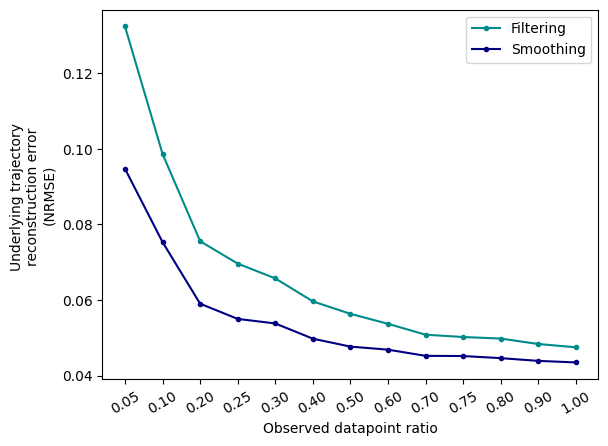

In [12]:
obs_ratios = [f'{1-i:.2f}' for i in p_drop_list]
f = plt.figure()
ax = f.add_subplot(111)
plt.plot(np.arange(len(p_drop_list)), dfine_nrmse_filter_list[::-1], marker='.', label='Filtering', color='#008B8B')
plt.plot(np.arange(len(p_drop_list)), dfine_nrmse_smooth_list[::-1], marker='.', label='Smoothing', color='#000080')
ax.set_xticks(np.arange(len(p_drop_list)))
ax.set_xticklabels(obs_ratios[::-1])
ax.set_xlabel('Observed datapoint ratio')
ax.set_ylabel('Underlying trajectory \nreconstruction error \n(NRMSE)')
plt.xticks(rotation=30)
plt.legend()
plt.show()

We can see that the same trained DFINE model can perform both filtering and smoothing, and can do so with or without missing observations. Also, the difference between filtering and smoothing is larger in the low information regime, that is for low observed datapoint ratios.

Finally, let's visualize the DFINE inferred filtered and smoothed trajectories for observed datapoint ratio of 0.1 (or sample dropping probability of 0.9). 

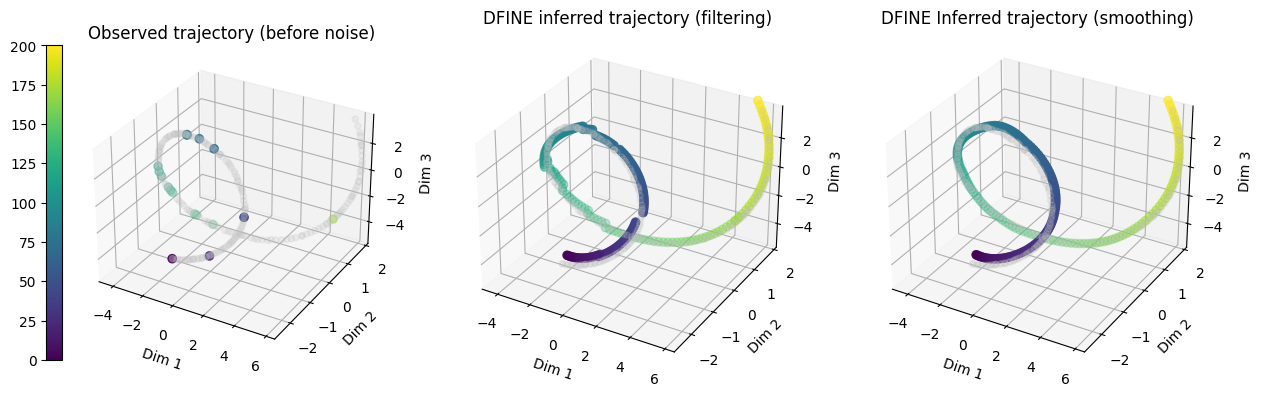

In [13]:
def plot_reconst_traj_3D_with_missing(y_no_noise, y_filter_drop, y_smooth_drop, mask, trial):
    num_samples = y_no_noise.shape[1]
    color_index = range(num_samples)
    color_map = plt.cm.get_cmap('viridis')
    
    xlim = [y_no_noise[trial, :, 0].min(), y_no_noise[trial, :, 0].max()]
    ylim = [y_no_noise[trial, :, 1].min(), y_no_noise[trial, :, 1].max()]
    zlim = [y_no_noise[trial, :, 2].min(), y_no_noise[trial, :, 2].max()]
    
    # Mask the missing samples with NaNs
    dim_y = y_no_noise.shape[-1]
    mask_rp = mask.repeat(1, 1, dim_y)
    y_masked = y_no_noise.clone()
    y_masked[mask_rp == 0] = torch.nan

    # Plot the true trajectory
    f = plt.figure(figsize=(15,12))
    ax = f.add_subplot(131, projection='3d')
    ax_m = ax.scatter(y_masked[trial, :, 0].numpy(), y_masked[trial, :, 1].numpy(), y_masked[trial, :, 2].numpy(), c=color_index, vmin=0, vmax=num_samples, s=35, cmap=color_map)
    ax.scatter(y_no_noise[trial, :, 0].numpy(), y_no_noise[trial, :, 1].numpy(), y_no_noise[trial, :, 2].numpy(), color='#C0C0C0', alpha=0.2)
    f.colorbar(ax_m, fraction=0.046, pad=0.04, shrink=0.4, location='left')
    ax.set_xlabel('Dim 1')
    ax.set_ylabel('Dim 2')
    ax.set_zlabel('Dim 3')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(zlim)
    ax.set_title('Observed trajectory (before noise)')

   # Plot the inferred trajectory from noisy observations with filtering
    ax = f.add_subplot(132, projection='3d')
    ax_m = ax.scatter(y_filter_drop[trial, :, 0].numpy(), y_filter_drop[trial, :, 1].numpy(), y_filter_drop[trial, :, 2].numpy(), c=color_index, vmin=0, vmax=num_samples, s=35, cmap=color_map)
    ax.scatter(y_no_noise[trial, :, 0].numpy(), y_no_noise[trial, :, 1].numpy(), y_no_noise[trial, :, 2].numpy(), color='#C0C0C0', alpha=0.2)
    ax.set_xlabel('Dim 1')
    ax.set_ylabel('Dim 2')
    ax.set_zlabel('Dim 3')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(zlim)
    title = 'DFINE inferred trajectory (filtering)'
    ax.set_title(title)

    # Plot the inferred trajectory from noisy observations with smoothing
    ax = f.add_subplot(133, projection='3d')
    ax_m = ax.scatter(y_smooth_drop[trial, :, 0].numpy(), y_smooth_drop[trial, :, 1].numpy(), y_smooth_drop[trial, :, 2].numpy(), c=color_index, vmin=0, vmax=num_samples, s=35, cmap=color_map)
    ax.scatter(y_no_noise[trial, :, 0].numpy(), y_no_noise[trial, :, 1].numpy(), y_no_noise[trial, :, 2].numpy(), color='#C0C0C0', alpha=0.2)
    ax.set_xlabel('Dim 1')
    ax.set_ylabel('Dim 2')
    ax.set_zlabel('Dim 3')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(zlim)
    title = 'DFINE Inferred trajectory (smoothing)'
    ax.set_title(title)
    plt.show()

# Plot DFINE inferred filtered and smoothed trajectories with missing samples
p_drop_plot = 0.9
p_drop_ind = np.where(p_drop_list==p_drop_plot)[0][0]
test_mask = mask_list[p_drop_ind]
dfine_test_y_filter_drop = dfine_y_filter_list[p_drop_ind]
dfine_test_y_smooth_drop = dfine_y_smooth_list[p_drop_ind]

plot_reconst_traj_3D_with_missing(test_y_no_noise, dfine_test_y_filter_drop, dfine_test_y_smooth_drop, test_mask, trial_plot)

Note that the left-most plot is for visualization and shows that only 10% of the underlying trajectory will be observed in noisy neural observations. This means that only the noisy neural observations associated with the colored dots on the trajectory are used for inference, and all other neural observations (associated with all the other points of trajectory) are missing during inference. 